# How to reach 94% Accuracy on CIFAR-10 using TensorFlow 2


In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    %load_ext tensorboard
except Exception:
    pass

import tensorflow as tf
import numpy as np
from tensorflow import keras
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)

2.2.0


In [2]:
!git clone https://github.com/nkaenzig/CLR.git
!mv CLR/clr_callback.py ./

Cloning into 'CLR'...
remote: Enumerating objects: 250, done.
remote: Total 250 (delta 0), reused 0 (delta 0), pack-reused 250
Receiving objects: 100% (250/250), 1.37 MiB | 4.00 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [3]:
from clr_callback import CyclicLR

In [4]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
!mkdir data
!tar zxf cifar10.tgz -C data/

--2020-06-16 23:20:32--  https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.207.29
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.207.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135107811 (129M) [application/x-tar]
Saving to: ‘cifar10.tgz’

cifar10.tgz         100%[===================>] 128.85M  39.0MB/s    in 3.3s    

2020-06-16 23:20:36 (39.0 MB/s) - ‘cifar10.tgz’ saved [135107811/135107811]



In [5]:
import pathlib
import os

cifar10_dir = 'data/cifar10/'
data_root = pathlib.Path(cifar10_dir)

class_names = sorted([e.name for e in (data_root/'train').iterdir() if e.is_dir()])
class_names_to_label = {name: label for label, name in enumerate(class_names)}
label_to_class_names = {label: name for label, name in enumerate(class_names)}

class_names_to_label

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [6]:
import random
all_image_paths = list(data_root.glob('*/*/*.png'))

random.shuffle(all_image_paths)

train_image_paths, train_image_labels, test_image_paths, test_image_labels = [], [], [], []

for path in all_image_paths:
    if path.parent.parent.name == 'train':
        train_image_paths.append(str(path))
        train_image_labels.append(class_names_to_label[path.parent.name])
        
    elif path.parent.parent.name == 'test':
        test_image_paths.append(str(path))
        test_image_labels.append(class_names_to_label[path.parent.name])

In [7]:
from functools import partial

IMG_SHAPE = (64, 64)
BATCH_SIZE = 64

def load_and_preprocess_image(image_path, label, img_shape):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, img_shape)
    image = tf.cast(image, tf.float32) / 127.5 - 1
    # image = tf.cast(image, tf.float32) / 255
    label = tf.cast(label, tf.float32)
    
    return image, label


def create_dataset(file_paths, labels, epochs=1, batch_size=64, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(partial(load_and_preprocess_image, img_shape=IMG_SHAPE), num_parallel_calls=AUTOTUNE)
    if train:
        dataset = dataset.cache(filename='./cache.tf-data')
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

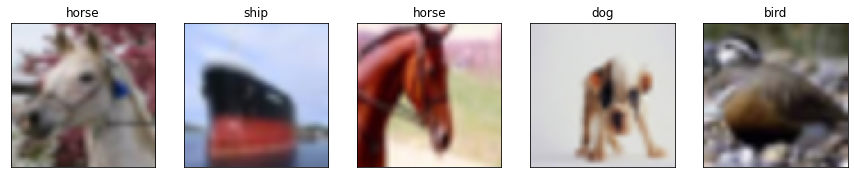

In [8]:
import matplotlib.pyplot as plt

ds = create_dataset(train_image_paths, train_image_labels, batch_size=5, train=False)

for batch, labels in ds.take(1):
    fig, ax = plt.subplots(1, len(batch), figsize=(15,20))
    for i, (img, label) in enumerate(zip(batch, labels)):
        fig.axes[i].imshow((img+1)/2)
        fig.axes[i].set_title(label_to_class_names[labels[i].numpy()])
        fig.axes[i].set_xticks([])
        fig.axes[i].set_yticks([])

In [9]:
def create_model(nr_classes, dropout=0):
    base_model = keras.applications.resnet_v2.ResNet50V2(weights="imagenet", include_top=False)
    
    for layer in base_model.layers:
        if layer.__class__.__name__ != "BatchNormalization":
            layer.trainable = False
    
    avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
    mx = keras.layers.GlobalMaxPooling2D()(base_model.output)
    out = tf.keras.layers.Concatenate()([avg, mx])
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Dropout(0)(out)
    out = keras.layers.Dense(512, activation="relu")(out)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Dropout(0)(out)
    out = keras.layers.Dense(nr_classes, activation="softmax")(out)
    
    model = keras.models.Model(inputs=base_model.input, outputs=out)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.003)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model


def unfreeze(model, nr_unfreezed_layers=None, lr=0.0001):
    if nr_unfreezed_layers == None:
        nr_freezed_layers = 0
    else:
        nr_freezed_layers = len(model.layers) - nr_unfreezed_layers

    model.trainable = True
    for i in range(len(model.layers)):
        if i < nr_freezed_layers:
            model.layers[i].trainable = False
        else:
            model.layers[i].trainable = True
            if nr_unfreezed_layers:
                print(f'Unfreezed Layer {i}: {model.layers[i]}')

    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [10]:
def train(model, train_dataset, train_size, val_dataset=None, val_size=None, nr_epochs=10, batch_size=32, one_cycle=False, max_lr=5e-3):
    steps_per_epoch = train_size // batch_size
    validation_steps = val_size // batch_size
    callbacks = []

    from datetime import datetime
    ts = str(int(datetime.now().timestamp()))

    # | Tensorboard
    log_dir = './log/' + ts
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch')
    callbacks.append(tb_callback)

    # | Checkpoints
    checkpoint_dir = './checkpoints/' + ts
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_dir + '/weights.{epoch:02d}-{val_loss:.2f}.h5',
                                                        save_weights_only=True,
                                                        save_freq='epoch',
                                                        monitor='val_loss',
                                                        save_best_only=True)

    if one_cycle:
        # from clr_callback import CyclicLR
        # max_lr = 5e-3
        step_size = (nr_epochs*steps_per_epoch)/2
        callbacks.append(CyclicLR(base_lr=max_lr/25, max_lr=max_lr, mode='triangular', step_size=step_size))

    else:
        # | Early Stopping
        earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto', restore_best_weights=True)
        callbacks.append(earlystop_callback)

        # | Learning Rate Reducer
        lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, verbose=1)
        callbacks.append(lr_reducer)
        callbacks.append(checkpoint_callback)

    # | Training
    history = model.fit(train_dataset,
                        epochs=nr_epochs,
                        steps_per_epoch = steps_per_epoch,
                        validation_data=val_dataset, 
                        validation_steps=validation_steps,
                        callbacks=callbacks)
    
    return model, history

In [12]:
batch_size = 64
train_size = len(train_image_paths)
val_size = len(test_image_paths)

## Stage-1: Training frozen model

In [13]:
nr_epochs = 5

model = create_model(len(class_names))

train_dataset = create_dataset(train_image_paths, train_image_labels, epochs=-1, batch_size=batch_size, train=True)
val_dataset = create_dataset(test_image_paths, test_image_labels, epochs=-1, batch_size=batch_size, train=False)

train(model, train_dataset, train_size, val_dataset, val_size, batch_size=batch_size, nr_epochs=nr_epochs, one_cycle=False, max_lr=1e-3)
model.save_weights('./step-1/checkpoint')

94674944/94668760 [==============================] - 1s 0us/step
Epoch 1/5
781/781 [==============================] - 38s 49ms/step - loss: 1.2508 - accuracy: 0.5811 - val_loss: 0.8523 - val_accuracy: 0.7054 - lr: 0.0030
Epoch 2/5
781/781 [==============================] - 36s 46ms/step - loss: 0.7239 - accuracy: 0.7461 - val_loss: 0.6669 - val_accuracy: 0.7710 - lr: 0.0030
Epoch 3/5
781/781 [==============================] - 36s 46ms/step - loss: 0.5474 - accuracy: 0.8076 - val_loss: 0.5933 - val_accuracy: 0.8005 - lr: 0.0030
Epoch 4/5
781/781 [==============================] - 36s 46ms/step - loss: 0.4372 - accuracy: 0.8461 - val_loss: 0.5743 - val_accuracy: 0.8096 - lr: 0.0030
Epoch 5/5
781/781 [==============================] - 36s 46ms/step - loss: 0.3555 - accuracy: 0.8717 - val_loss: 0.5518 - val_accuracy: 0.8232 - lr: 0.0030


## Stage-2: Fine-Tuning complete model

In [16]:
model = create_model(len(class_names))
model.load_weights('./step-1/checkpoint')

model = unfreeze(model)

train(model, train_dataset, train_size, val_dataset, val_size, batch_size=batch_size, nr_epochs=nr_epochs, one_cycle=True, max_lr=1e-4)


Epoch 1/5
781/781 [==============================] - 49s 63ms/step - loss: 0.8040 - accuracy: 0.7340 - val_loss: 2.4833 - val_accuracy: 0.4769
Epoch 2/5
781/781 [==============================] - 48s 61ms/step - loss: 0.9275 - accuracy: 0.6886 - val_loss: 84520.2031 - val_accuracy: 0.1000
Epoch 3/5
781/781 [==============================] - 48s 61ms/step - loss: 1.0566 - accuracy: 0.6359 - val_loss: 0.8306 - val_accuracy: 0.7144
Epoch 4/5
781/781 [==============================] - 48s 61ms/step - loss: 0.5672 - accuracy: 0.8050 - val_loss: 0.6161 - val_accuracy: 0.7899
Epoch 5/5
781/781 [==============================] - 48s 61ms/step - loss: 0.3080 - accuracy: 0.8942 - val_loss: 0.6289 - val_accuracy: 0.8460


(<tensorflow.python.keras.engine.training.Model at 0x7f21f93ffda0>,
 <tensorflow.python.keras.callbacks.History at 0x7f21f931e898>)